In [2]:
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
df_train = pd.read_csv('metadata of train set .csv')
print(df_train.columns)
df_train.head(10)

Index(['Filename', 'File ID', 'Duration in ms', 'Class ID', 'Classname',
       'augmentation  id', 'Augmentation  type', 'source'],
      dtype='object')


,Filename,File ID,Duration in ms,Class ID,Classname,augmentation id,Augmentation type,source
0,108160-1_0_0.wav,108160,3730,0,breath,0,Orignal,https://freesound.org/
1,108160-2_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/
2,108160-3_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/
3,108160-4_0_0.wav,108160,2226,0,breath,0,Orignal,https://freesound.org/
4,146769-1_0_0.wav,146769,3540,0,breath,0,Orignal,https://freesound.org/
5,151215_0_0.wav,151215,3690,0,breath,0,Orignal,https://freesound.org/
6,162254-1_0_0.wav,162254,4000,0,breath,0,Orignal,https://freesound.org/
7,162254-2_0_0.wav,162254,4000,0,breath,0,Orignal,https://freesound.org/
8,164101-32_0_0.wav,164101,3860,0,breath,0,Orignal,https://freesound.org/
9,169222-1_0_0.wav,169222,3690,0,breath,0,Orignal,https://freesound.org/


In [4]:
import librosa
import numpy as np

def extract_features(y, sr, n_mfcc=15, n_mels=128):
    # **MFCC Features**
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)  # (n_mfcc,)

    # **Delta MFCC (First Order Derivative)**
    delta_mfcc = librosa.feature.delta(mfcc)
    delta_mfcc_mean = np.mean(delta_mfcc, axis=1)  # (n_mfcc,)

    # **Zero-Crossing Rate**
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))  # (1,)

    # **RMS Energy**
    rms = np.mean(librosa.feature.rms(y=y))  # (1,)

    # **Spectral Features**
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))  # (1,)
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))  # (1,)
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))  # (1,)

    # **Pitch (Fundamental Frequency)**
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0  # (1,)

    # **Log-Mel Spectrogram Features**
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec)
    mel_spec_mean = np.mean(mel_spec_db, axis=1)  # (n_mels,)

    # **Combine all features into a single array**
    features = np.hstack((
        mfcc_mean, delta_mfcc_mean,  # MFCC & Delta
        [zcr, rms, spectral_centroid, spectral_bandwidth, spectral_rolloff, pitch],  # Spectral Features
        mel_spec_mean,  # Log-Mel Spectrogram Features
    ))

    return features


features = []
labels = []

for i, row in tqdm.tqdm(df_train.iterrows(), desc='Processing Audio', total=len(df_train)):
    path = 'train/' + row['Filename']
    
    # Load the audio file and remove silence
    y, sr = librosa.load(path, sr=None)  # Keep original sample rate
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)  # Trim silent parts
    extracted_features = extract_features(y,sr)
    features.append(extracted_features)
    labels.append(row['Class ID'])

features = np.array(features)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print("Final Feature Shape:", features_scaled.shape)

Processing Audio:  23%|██▎       | 1456/6289 [04:45<15:47,  5.10it/s]


KeyboardInterrupt: 

In [64]:
ffeat=features_scaled
lbls=labels

In [65]:
features_scaled=ffeat
labels=lbls

In [67]:
import torch
import numpy as np
from torch.nn.functional import one_hot

X = np.array(features_scaled)
y = np.array(labels)

print(X.shape, y.shape)
print('Done')

(6289, 35) (6289,)
Done


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class DeepLSTM(nn.Module):
    def __init__(self, input_size=35, hidden_size=128, num_layers=3, num_classes=10, dropout=0.3):
        super(DeepLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=dropout)

        self.fc1 = nn.Linear(hidden_size * 2, 128)  # BiLSTM output
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # Take last time-step output

        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Initialize model
num_classes = 7
model = DeepLSTM(input_size=35, num_classes=num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

c:\Users\91820\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Using device: cuda


In [16]:
import torch
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert to NumPy
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int64)  # Assuming y is not one-hot encoded

# Shuffle data
X, y = shuffle(X, y, random_state=42)

# Apply SMOTE to balance classes
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X, y)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_sm, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_sm, dtype=torch.long).to(device)

# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training dataset size: {len(train_loader.dataset)}")


Using device: cuda


NameError: name 'X' is not defined

In [230]:
from collections import Counter
print("Before SMOTE:", Counter(y))
print("After SMOTE:", Counter(y_train_sm))


Before SMOTE: Counter({2: 1791, 0: 1690, 3: 1133, 1: 632, 4: 593, 5: 236, 6: 214})
After SMOTE: Counter({6: 1791, 0: 1791, 2: 1791, 3: 1791, 4: 1791, 1: 1791, 5: 1791})


In [ ]:

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f} - Train Acc: {train_acc:.4f}")

Epoch [1/10], Loss: 286.6233, Train Accuracy: 0.4255
Epoch [2/10], Loss: 220.1233, Train Accuracy: 0.5682
Epoch [3/10], Loss: 193.8686, Train Accuracy: 0.6261
Epoch [4/10], Loss: 175.9681, Train Accuracy: 0.6611
Epoch [5/10], Loss: 155.2708, Train Accuracy: 0.7084
Epoch [6/10], Loss: 137.7112, Train Accuracy: 0.7389
Epoch [7/10], Loss: 119.5840, Train Accuracy: 0.7762
Epoch [8/10], Loss: 106.1221, Train Accuracy: 0.8063
Epoch [9/10], Loss: 95.9450, Train Accuracy: 0.8209
Epoch [10/10], Loss: 81.0516, Train Accuracy: 0.8482


In [49]:
df_test =pd.read_csv('metadata of test set.csv')
df_test.drop([ 'Augment Id','Augmentation type'], axis=1, inplace=True)
df_test.head(5)

,Filename,File_ID,Durationin ms,Class_id,Classname,source
0,112557-2_0_0.wav,112557,4000,0,breath,https://freesound.org/
1,112557-3_0_0.wav,112557,3950,0,breath,https://freesound.org/
2,112557-4_0_0.wav,112557,3910,0,breath,https://freesound.org/
3,140301_0_0.wav,140301,2261,0,breath,https://freesound.org/
4,144128-1_0_0.wav,144128,3770,0,breath,https://freesound.org/


In [50]:
features_test = []
labels_test = []

for i, row in tqdm.tqdm(df_test.iterrows(), desc='Loading : ', total=len(df_test)):
    path = 'test/' + row['Filename']
    y,sr=librosa.load(path)
    extracted_features_test = extract_features(y,sr)
    features_test.append(extracted_features_test)
    labels_test.append(row['Class_id'])

# Convert to NumPy array
features_test = np.array(features_test)

# Standardize the features_test
scaler = StandardScaler()
features_test_scaled = scaler.fit_transform(features_test)

print("Final Feature Shape:", features_test_scaled.shape) 

Loading : 100%|██████████| 725/725 [01:12<00:00,  9.96it/s]

Final Feature Shape: (725, 35)


In [ ]:
X_test =features_test_scaled
y_test =labels_test
X_test = np.array(X_test) 
y_test = np.array(y_test) 
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [ ]:
from sklearn.metrics import classification_report, f1_score, accuracy_score
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
classification_rep = classification_report(all_labels, all_preds)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", classification_rep)

Feature Extraction Complete! Train Shape: (12537, 10), Test Shape: (725, 10)


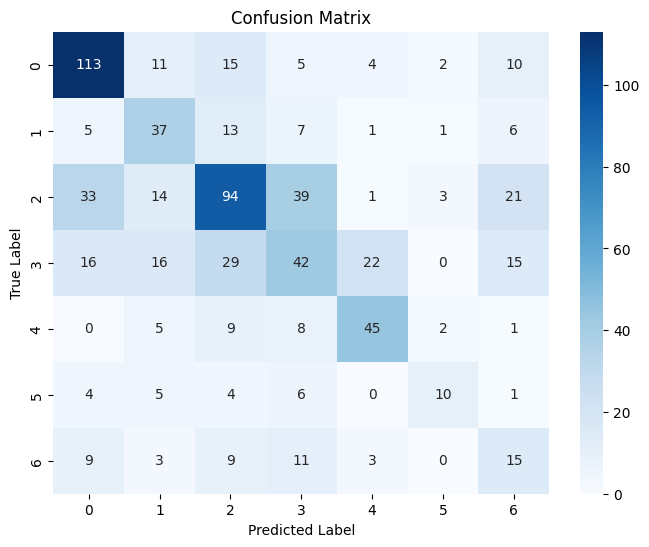

In [ ]:
from sklearn.metrics import (
    classification_report)
conf_matrix = confusion_matrix(test_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()